# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Цель исследования — проверьте четыре гипотезы:**

Есть зависимость между наличием детей и возвратом кредита в срок.

Есть зависимость между семейным положением и возвратом кредита в срок.

Есть зависимость между уровнем дохода и возвратом кредита в срок.

Разные цели кредита влияют на его возврат в срок.


## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
from pymystem3 import Mystem #сразу добавим Mystem
import matplotlib.pyplot as plt
import seaborn as sns
m = Mystem()

In [2]:
class Analisys:
    
    def unique_value_in_columns(self, data):
        value = data.columns.values.tolist()
        data_p = pd.DataFrame()
        for val in value: #создаем цикл по просмотру уникальных значений по столбцам, ограничим вывод 15 строками
            if data[val].dtypes == object:
                print(f'уникальные значения в {val}: {data[val].unique()}')
                print('')
            else:
                data_p[val] = data[val]
        display(data_p.describe())
    
    def min_mean_max_values_in_groupe(self, data, column_for_group, column_for_operations, val_correction=1, median=False):# создадим функцию по выводу данных по группам 
        try:
            values = data[column_for_group].unique().tolist()
            if median == False:
                for val in values:
                    output_min = data[data[column_for_group] == val][column_for_operations].min()
                    output_mean = data[data[column_for_group] == val][column_for_operations].mean()
                    output_max = data[data[column_for_group] == val][column_for_operations].max()
                    print(f'минимальное значение для {column_for_operations} по группе {val} равно: {output_min/val_correction}')
                    print(f'среднее значение для {column_for_operations} по группе {val} равно: {output_mean/val_correction}')
                    print(f'максимальное значение для {column_for_operations} по группе {val} равно: {output_max/val_correction}')
                    print('')
            else:
                for val in values:
                    output_min = data[data[column_for_group] == val][column_for_operations].min()
                    output_median = data[data[column_for_group] == val][column_for_operations].median()
                    output_max = data[data[column_for_group] == val][column_for_operations].max()
                    print(f'минимальное значение для {column_for_operations} по группе {val} равно: {output_min/val_correction}')
                    print(f'медианное значение для {column_for_operations} по группе {val} равно: {output_median/val_correction}')
                    print(f'максимальное значение для {column_for_operations} по группе {val} равно: {output_max/val_correction}')
                    print('')
        except:
            print('Error')
    
    def lemmatize(self, data, column):
        text=''
        list_lemma = data[column].tolist()
        for lem in list_lemma:
            text += lem + '|'
        
        doc = []
        res = []
        
        for t in m.lemmatize(text):
            if t != '|':
                doc.append(t)
            else:
                res.append(doc)
                doc = []
        res.append(doc)
        return res
    
    def total_income_level(self, income): #разобъем на категории уровень дохода
        if income < 90000:
            return 'низкий'
        elif 90000 <= income < 160000:
            return 'средний'
        elif 160000 <= income < 280000:
            return 'выше среднего'
        else:
            return 'высокий'
    
    def purpose_categories(self, lemmas): #категоризируем цели кредита
        try:
            if 'автомобиль' in lemmas :
                return 'автомобиль'
            elif 'образование' in lemmas:
                return 'образование'
            elif 'свадьба' in lemmas:
                return 'свадьба'
            elif 'семья' in lemmas:
                return 'свадьба'
            elif 'жилье' in lemmas:
                return 'недвижимость'
            elif 'недвижимость' in lemmas:
                return 'недвижимость'
            elif 'сдача' in lemmas:
                return 'недвижимость'
            elif 'ремонт' in lemmas:
                return 'недвижимость'
            else:
                return 'другое'
        except:
            print('здесь ошибка')
    
    def children_categories(self, children): #категоризируем количество детей
        try:
            if children == 0:
                return 'нет детей'
            elif children == 1:
                return 'один ребенок'
            elif children == 2:
                return 'двое детей'
            else:
                return 'многодетные'
        except:
            print('здесь ошибка')
    
    def years_categories(self, years): #категоризирум возраст
        try:
            if years < 35:
                return 'молодой возраст'
            elif 35 <= years < 55:
                return 'средний возраст'
            else:
                return 'пожилой возраст'
        except:
            print('здесь ошибка')
    
    def employed_categories(self, employed): #категоризирум стаж
        try:
            if employed < 365:
                return 'меньше года'
            elif 365 <= employed < 1826:
                return 'до пяти лет'
            elif 1826 <= employed < 3652:
                return 'до десяти лет'
            else:
                return 'свыше десяти лет'
        except:
            print('здесь ошибка')
    
    def ratio_in_procent(self, x): #объявим переменную для вывода разницы в процентах для подстановки в aggfunc
        ratio = round(x.sum()/x.shape[0]*100,2)
        return ratio
    
    def cat_debt_pivot(self, data, category, col_pivot):
        #объявим переменную c сводной таблицей по категории
        df_debt_all = data['debt'].sum() / data['debt'].count()
    
        t_piv_0 = data.pivot_table(index=category, values='debt', aggfunc=['sum','count', self.ratio_in_procent])
        display(t_piv_0, 'Невозврат кредита по всей выборке: {:.2%}'.format(df_debt_all))
        t_piv_1 = df.pivot_table(index=category, columns=col_pivot, values='debt', aggfunc= self.ratio_in_procent)
        display(t_piv_1)
        plt.figure(figsize=(3,2))
        sns.heatmap(t_piv_1,annot=True, cmap="OrRd")
        plt.show()
            #объявим переменную c сводной таблицей по категории с группировкой по ктегориям
    
    
an = Analisys()

In [3]:
try: # открываем файл
    df = pd.read_csv('/datasets/data.csv') 
except: # альтернативный путь к файлу в случае ошибки
    df = pd.read_csv(r'C:\Users\EliteBook\Downloads\data.csv') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


По выведенной информации о таблице видим, что имеется 12 колонок: 2 колонки с типом float64, 5 колонок с типом int64 и 5 колонок типа object. Количество значений в столбцах различается. Значит, в данных есть пропущенные значения. Выведем первые 15 строк данных:

In [4]:
display(df.head(15))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


**Вывод**

Согласно документации к данным:
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

По выведенным первым 15 строкам видна разный тип, регистр заполнения данных в ячейках колонок, требуется проверка на наличие пропусков, дубликатов и устранение ошибок в записи данных

## Шаг 2. Предобработка данных

### Обработка пропусков

Рассмотрим распределение пропусков по столбцам:

In [5]:
print(df.isna().sum()) #выведем количество явных пропусков по столбцам

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


Проверим распределение пропусков по типу занятости:

In [6]:
income_type_list = df['income_type'].unique().tolist() # создадим список по типу занятости
for val in income_type_list: # обявление цикла по поиску пропусков по типу занятости
    output_info = df[df['income_type'] == val]['total_income'].isna().sum()
    print(f'пропуски значений по типузанятости {val}: {output_info}')

пропуски значений по типузанятости сотрудник: 1105
пропуски значений по типузанятости пенсионер: 413
пропуски значений по типузанятости компаньон: 508
пропуски значений по типузанятости госслужащий: 147
пропуски значений по типузанятости безработный: 0
пропуски значений по типузанятости предприниматель: 1
пропуски значений по типузанятости студент: 0
пропуски значений по типузанятости в декрете: 0


Отсутствуют данные в колонках общий трудовой стаж в днях и ежемесячный доход и они совпадают
Проверив распределение пропусков по типу занятости присвоим для провусков значения стажа и заработка по медиане групп, предварительно обработав ошибки.
Выведем уникальные значения в столбцах:

In [7]:
an.unique_value_in_columns(df)

уникальные значения в education: ['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']

уникальные значения в family_status: ['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']

уникальные значения в gender: ['F' 'M' 'XNA']

уникальные значения в income_type: ['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']

уникальные значения в purpose: ['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покуп

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Оценив уникальные Значения в столбцах, видим ошибки в заполнении, приступаем к исправлению значений, например в значении количества детей из сета данных есть значение -1, а значение 20 детей стоит очень далеко от предпоследнего в 5 детй. в других столбцах так же есть подобные ошибки, усправим их.

In [8]:
df['children'] = df['children'].abs().astype('int64') # через присвоение модуля значений убираем ошибочные отрицательные значения
df.loc[(df['children'] == 20), 'children'] = int(df[df['children'] != 0]['children'].median()) # меняем значение 20 детей на медианное количество детей семей с детьм

In [9]:
df.loc[(df['gender'] == 'XNA'), 'gender'] = 'F'

In [10]:
df['days_employed'] = df['days_employed'].abs() #через присвоение модуля значений убираем ошибочные отрицательные значения

In [11]:
df.loc[(df['dob_years'] == 0), 'dob_years'] = int(df[df['dob_years'] != 0]['dob_years'].median()) #заменяем значение возраста 0 на медианное значение

In [12]:
df['education'] = df['education'].str.lower() #выравниваем строки с образованием на нижний регистр

In [13]:
df['total_income'] = df['total_income'].abs() #через присвоение модуля значений убираем ошибочные отрицательные значения

Устранив ошибки ввода по категорийным данным и приведя данные по количественным данным к положительным значениям проверим количественные данные на ошибки по реальности цифр, разбив на группы по типу занятости.

In [14]:
an.min_mean_max_values_in_groupe(df,'income_type','days_employed',365)

print('Произошла ошибка, проверьте введенные данные')
print('''посчитаем значения стажа по группам в годах
''')

минимальное значение для days_employed по группе сотрудник равно: 0.06614146093282515
среднее значение для days_employed по группе сотрудник равно: 6.373970454717277
максимальное значение для days_employed по группе сотрудник равно: 50.38068465909146

минимальное значение для days_employed по группе пенсионер равно: 900.6266317932007
среднее значение для days_employed по группе пенсионер равно: 1000.009565054413
максимальное значение для days_employed по группе пенсионер равно: 1100.6997273296713

минимальное значение для days_employed по группе компаньон равно: 0.08272695111112224
среднее значение для days_employed по группе компаньон равно: 5.7849983515006285
максимальное значение для days_employed по группе компаньон равно: 48.26181716610387

минимальное значение для days_employed по группе госслужащий равно: 0.10946348065301145
среднее значение для days_employed по группе госслужащий равно: 9.31478603204314
максимальное значение для days_employed по группе госслужащий равно: 41.624

Видим очень странные цифры в группах пенсионер и безработный по годам стажа, предположим в этих колонках стаж указан не в дня а часах, проверим предположение, но стоит задать вопрос по данным сотрудникам заказчика исследования, предоставившим датасет

In [15]:
days_mean_pension = df[df['income_type'] == 'пенсионер']['days_employed'].mean()  #вводим переменную для сохранения среднего значения
if (days_mean_pension) >= 365002: #пишем условие для исключения цикличной перезаписи значений
    df_pension_employed = df[df['income_type'] == 'пенсионер']['days_employed'] #вводим переменную для сохранения series 
    df_pension_employed /= 24
    df.loc[(df['income_type'] == 'пенсионер'),'days_employed'] = df_pension_employed #заменяем значения
days_mean_pension = df[df['income_type'] == 'пенсионер']['days_employed'].mean()
print(f'разделенные на 24 часа данные в значениях стажа по группе пенсионеры в среднем дают {days_mean_pension/365.25} года, что близко к реальности')

print(f'выясним количество записей и средний возраст безработного:')

count_unemployed = df[df['income_type'] == 'безработный']['dob_years'].count()
mean_unemployed_years = df[df['income_type'] == 'безработный']['dob_years'].mean()

print(f'количество записей в группе безработные: {count_unemployed}')
print(f'средний возраст в группе безработные: {mean_unemployed_years}')
print('''из полученных данных видим, что в данном случае правильно стаж по группе безработных присвоить
исходя из среднего стажа по возрасту в 38 лет''')

days_mean_38_years = df[df['dob_years'] == 38]['days_employed'].mean() #вводим переменную для сохранения среднего значения стажа в группе 38 лет
days_mean_unemployed = df[df['income_type'] == 'безработный']['days_employed'].mean()
if days_mean_unemployed >= 366413: #пишем условие для исключения цикличной перезаписи значений
    df.loc[(df['income_type'] == 'безработный'),'days_employed'] = days_mean_38_years #заменяем значения
days_mean_unemployed = df[df['income_type'] == 'безработный']['days_employed'].mean()


print(f'после замены на средний стаж по возрасту 38 лет стаж безработных получается: {days_mean_unemployed/365.25} года')
print('')
print('теперь заменим пропущенные значения по стажу средними значениями с разбивкой по группам занятости')
print('')

income_type_list = df['income_type'].unique().tolist()
try:
    for val in income_type_list:
        mean_val = df[df['income_type'] == val]['days_employed'].mean() #получаем среднее значение по типу занятости
        income_val = df[df['income_type'] == val]['days_employed'] # создаем series по типу занятости
        income_val = income_val.fillna(mean_val) # удаляем пропуски в series
        df.loc[(df['income_type'] == val),'days_employed'] = income_val # заменяем значения в фрейме
except:
    print('ошибка')
df.isna().sum()


разделенные на 24 часа данные в значениях стажа по группе пенсионеры в среднем дают 41.63854565877951 года, что близко к реальности
выясним количество записей и средний возраст безработного:
количество записей в группе безработные: 2
средний возраст в группе безработные: 38.0
из полученных данных видим, что в данном случае правильно стаж по группе безработных присвоить
исходя из среднего стажа по возрасту в 38 лет
после замены на средний стаж по возрасту 38 лет стаж безработных получается: 6.835911880286787 года

теперь заменим пропущенные значения по стажу средними значениями с разбивкой по группам занятости



children               0
days_employed          0
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [16]:
print('''посмотрим на данные по месячным заработкам по группам занятости:
''')

an.min_mean_max_values_in_groupe(df,'income_type','total_income',median=True)


print('''
Значения неоднозначные, например медианный заработок пенсионера всего на 15% ниже медианного заработка сотрудника,
что не похоже на показатели в России, но тут нужно обращаться к тем, кто предоставил датафрейм,
заменим пропуски используя медианные значения по типу занятости
''')

try:
    for val in income_type_list:
        median_val = df[df['income_type'] == val]['total_income'].median() #получаем среднее значение по типу занятости
        total_income_val = df[df['income_type'] == val]['total_income'] # создаем series по типу занятости
        total_income_val = total_income_val.fillna(median_val) # удаляем пропуски в series
        df.loc[(df['income_type'] == val),'total_income'] = total_income_val # заменяем значения в фрейме
except:
    print('ошибка')
    
df.isna().sum()

посмотрим на данные по месячным заработкам по группам занятости:

минимальное значение для total_income по группе сотрудник равно: 21367.64835648697
медианное значение для total_income по группе сотрудник равно: 142594.39684740017
максимальное значение для total_income по группе сотрудник равно: 1726276.0143316735

минимальное значение для total_income по группе пенсионер равно: 20667.26379327158
медианное значение для total_income по группе пенсионер равно: 118514.48641164352
максимальное значение для total_income по группе пенсионер равно: 735103.2701666558

минимальное значение для total_income по группе компаньон равно: 28702.812888839853
медианное значение для total_income по группе компаньон равно: 172357.95096577113
максимальное значение для total_income по группе компаньон равно: 2265604.028722744

минимальное значение для total_income по группе госслужащий равно: 29200.07719298284
медианное значение для total_income по группе госслужащий равно: 150447.9352830068
максимальное з

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**

   В данных есть пропуски в столбцах с количественными данными по стажу работников и месячному доходу, в связи с тем, что мы будем исследовать влияние уроввня дохода на возврат кредита, данные с пропусками были заменены с разбивкой по типу занятости на средние и медианные значения.
   
   Оценив уникальные значения в столбцах, исправлены ошибки в заполнении данных по разным столбцам, выравнены данные, заполненые разным  регистром.
   
   Возможная причина появления пропусков скорее всего ошибка записи данных, на это указывает то, что пропуски встречаются только в двух столбцах.
   
   Ошибки в записи данных распределены случайным образом по определенным столбцам, что возможно указывает на неполное или неточное заполнение данных клиентами.

### Замена типа данных

В колличественных данных по дням занятости и по уровню месечного заработка данные воспринимать тяжело, заменим тип float64 на int64


In [17]:
df['days_employed'] = df['days_employed'].round(0).astype('int64') #округляем значения в столбце и меняем тип на int64
df['total_income'] = df['total_income'].round(0).astype('int64') #округляем значения в столбце и меняем тип на int64
df.info()
display(df.head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8438,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876,покупка жилья
1,1,4025,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья
3,3,4125,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629,дополнительное образование
4,0,14178,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255764,покупка жилья
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240526,операции с жильем
7,0,153,50,среднее,1,женат / замужем,0,M,сотрудник,0,135824,образование
8,2,6930,35,высшее,0,гражданский брак,1,F,сотрудник,0,95857,на проведение свадьбы
9,0,2189,41,среднее,1,женат / замужем,0,M,сотрудник,0,144426,покупка жилья для семьи


**Вывод**

Для замены данных используем метод смены типа данных столбца "astype", предворительно округлив значения через "round"
После замены типа значений данные стало читать и оценивать легче

### Обработка дубликатов

In [18]:
print(f'Количество дубликатов строк в датасете: {df.duplicated().sum()}, удалим дублированные строки')
df = df.drop_duplicates().reset_index(drop=True)

Количество дубликатов строк в датасете: 71, удалим дублированные строки


**Вывод**

Дубликаты удалены методом "drop_duplicates" с перезаписью индекса строк, так как выше скрытые дубликаты в столбцах были
устранены через приведение данных к общему виду записи.
Возможные причины образования дубликатов - ошибка при записи данных при заполнении заявки, повторное заполнение формы клиентом.

### Лемматизация

In [19]:
df['purpose_lemmas'] = an.lemmatize(df, column='purpose')

**Вывод**

В таблицу добавлен столбец с леммами слов из столбца с целями кредита, для этого подключили Mystem из библиотеки pymystem

### Категоризация данных

In [20]:
stop_words = [' ','.',',','!','?','|','а','и','на','с','со','в','для','покупка','приобретение','дополнительный',\
              'коммерческий', 'жилой', 'строительство', 'собственный', 'подержать', 'свой', 'со', 'заниматься',\
              'получение', 'высокий', 'подержанный', 'профильный', '|\n', 'сыграть', 'проведение']
clear_lemmas_list = [] # очистим общий список лемм от дубликатов и оценим основные леммы для категоризации целей кредитов

text=''
list_lemma = df['purpose'].tolist()
for lem in list_lemma:
    text += lem + '|'
    
full_text = m.lemmatize(text)
for t in full_text:
    if t not in clear_lemmas_list:
        if t not in stop_words:
            clear_lemmas_list.append(t)
print(f'Рассмотрим список лемм для выбора ключевых лемм для категоризации целей: {clear_lemmas_list}\n \n')
for l in clear_lemmas_list:
    count=0
    for t in full_text:
        if t==l:
            count += 1
    print(f'Повторение леммы {l} = {count} раз')

df['total_income_level'] = df['total_income'].apply(an.total_income_level)
df['purpose_categories'] = df['purpose_lemmas'].apply(an.purpose_categories)
df['children_categories'] = df['children'].apply(an.children_categories)
df['dob_years_categories'] = df['dob_years'].apply(an.years_categories)
df['years_employed_categories'] = df['days_employed'].apply(an.employed_categories)


df_educ = df.groupby('education')['debt'].count()
df_family = df.groupby('family_status')['debt'].count()


df.loc[df['education'] == 'начальное', 'education'] = 'среднее'
df.loc[df['education'] == 'неоконченное высшее', 'education'] = 'высшее'
df.loc[df['education'] == 'ученая степень', 'education'] = 'высшее'

df.loc[df['family_status'] == 'в разводе', 'family_status'] = 'в разводе / вдовец / вдова'
df.loc[df['family_status'] == 'вдовец / вдова', 'family_status'] = 'в разводе / вдовец / вдова'

Рассмотрим список лемм для выбора ключевых лемм для категоризации целей: ['жилье', 'автомобиль', 'образование', 'свадьба', 'операция', 'семья', 'недвижимость', 'сделка', 'сдача', 'ремонт']
 

Повторение леммы жилье = 4460 раз
Повторение леммы автомобиль = 4306 раз
Повторение леммы образование = 4013 раз
Повторение леммы свадьба = 2324 раз
Повторение леммы операция = 2604 раз
Повторение леммы семья = 638 раз
Повторение леммы недвижимость = 6351 раз
Повторение леммы сделка = 941 раз
Повторение леммы сдача = 651 раз
Повторение леммы ремонт = 607 раз


Леммы жилье, недвижимость, сдача, ремонт можно считать одной группой, самой популярной в запросах на кредит, затем идет покупка автомобиля, образование, свадьба.

**Вывод**

Для исследования категоризированны данные по уровню дохода, целям кредита, наличию детей, возрасту заемщика, стажу. 

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

,sum,count,ratio_in_procent
,debt,debt,debt
children_categories,,,
двое детей,194,2052,9.45
многодетные,31,380,8.16
нет детей,1063,14091,7.54
один ребенок,453,4931,9.19


'Невозврат кредита по всей выборке: 8.12%'

family_status,Не женат / не замужем,в разводе / вдовец / вдова,гражданский брак,женат / замужем
children_categories,,,,
двое детей,12.00,9.90,8.75,9.46
многодетные,20.00,5.26,12.12,7.02
нет детей,9.28,6.62,8.39,6.91
один ребенок,11.45,7.20,11.96,8.19


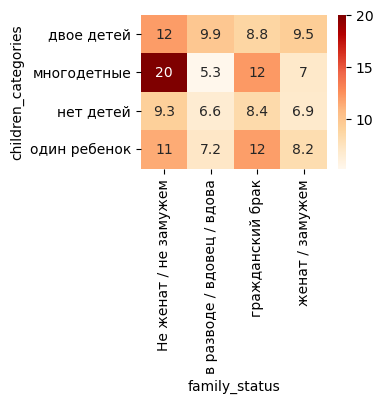

In [21]:
an.cat_debt_pivot(df, 'children_categories', 'family_status')

**Вывод**

- При сравнении показателей по сводным таблицам, видно, что при отсутствии детей процент невозврата кредита ниже среднего по всем данным сета, при наличие детей выше среднего, при разбивке на 1, 2 и 3+ детей в семье, при наличие 1 или 2 детей процент невыплаты выше среднего, для семей с 3+ деней выборка недостаточно, сложно оценить,
- При рассмотрении влияния наличия детей с разбивкой на семейный статус видно значительное взаимное влияние факторов по количеству детей и семейному статусу.

Есть зависимость между наличием детей и возвратом кредита в срок. Заемщики без детей надежнее чем с детьми, но наличие одного ребенка для групп заемщиков в браке или бывших в браке не выше среднего риска, наибольший процент невозврата кредита в срок приходится на заемщика с детьми не в браке или в гражданском браке.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

,sum,count,ratio_in_procent
,debt,debt,debt
family_status,,,
Не женат / не замужем,274,2810,9.75
в разводе / вдовец / вдова,148,2154,6.87
гражданский брак,388,4151,9.35
женат / замужем,931,12339,7.55


'Невозврат кредита по всей выборке: 8.12%'

years_employed_categories,до десяти лет,до пяти лет,меньше года,свыше десяти лет
family_status,,,,
Не женат / не замужем,9.36,11.74,12.61,5.05
в разводе / вдовец / вдова,5.59,8.60,9.09,6.36
гражданский брак,10.27,10.95,11.96,5.84
женат / замужем,7.75,9.47,9.50,5.10


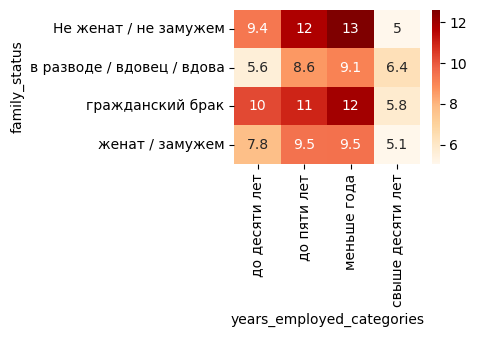

In [22]:
an.cat_debt_pivot(df, 'family_status', 'years_employed_categories')

**Вывод**

- При сравнении показателей по сводным таблицам, видно, что семейный статус влияет на возврат кредита в срок. В статусах в женат/замужем и в разводе/вдовец/вдова доля невозврата кредита в срок ниже чем у групп не женатых и состоящих в гражданском браке.
- При рассмотрении влияния наличия статуса с разбивкой на стаж видно понижение процента невозврата кредита в срок с ростом стажа практически во всех группах.

Есть зависимость между семейным положением и возвратом кредита в срок. Кредитовать людей состоящих или состоявших в браке надежнее.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

,sum,count,ratio_in_procent
,debt,debt,debt
total_income_level,,,
высокий,134,1890,7.09
выше среднего,534,6830,7.82
низкий,262,3348,7.83
средний,811,9386,8.64


'Невозврат кредита по всей выборке: 8.12%'

education,высшее,среднее
total_income_level,,
высокий,4.98,9.19
выше среднего,5.98,8.77
низкий,6.32,8.09
средний,5.75,9.54


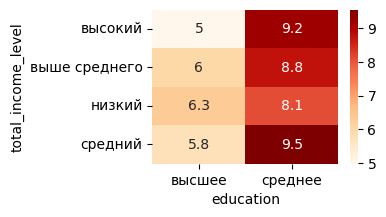

In [23]:
an.cat_debt_pivot(df, 'total_income_level', 'education')

**Вывод**

- При сравнении показателей по сводным таблицам, видно, что уровень дохода влияет на возврат кредита в срок незначительно. В группе с высокими доходами процент невозврата ниже, в остальных группах близок к среднему по сету данных.
- При рассмотрении влияния уровня дохода с разбивкой на образование видно, что в группе с высшим образованием примерно соблюдается последовательность: чем выше доход тем ниже процент невозврата в срок. В группе с средним образованием такой последовательности по уровню дохода не прослеживается.

Зависимость невозврата кредита в срок от уровня дохода есть в группе с вышим образованием, в общем по группе четкой зависимости нет. Стоит обращать внимание на уровень дохода заемщиков с высшим образованием.

- Как разные цели кредита влияют на его возврат в срок?

,sum,count,ratio_in_procent
,debt,debt,debt
purpose_categories,,,
автомобиль,403,4306,9.36
недвижимость,737,10173,7.24
образование,370,4013,9.22
свадьба,231,2962,7.80


'Невозврат кредита по всей выборке: 8.12%'

dob_years_categories,молодой возраст,пожилой возраст,средний возраст
purpose_categories,,,
автомобиль,12.77,6.19,8.95
недвижимость,9.73,4.95,6.83
образование,13.07,6.30,8.44
свадьба,9.43,5.18,8.09


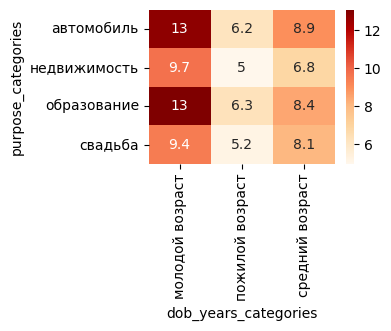

In [24]:
an.cat_debt_pivot(df, 'purpose_categories', 'dob_years_categories')

**Вывод**

- При сравнении показателей по сводным таблицам, видно, что цель кридита влияет на возврат кредита в срок. Для целей кредита на недвижимость процент невозврата в срок ниже других групп и ниже среднего процента по сету. Для цели свадьба процент невозврата вовремя примерно равен среднему проценту по сету. Для целей на автомобиль и на образование процент невозврата вовремя выше целей на недвижимость и не свадьбу и выше среднего по сету.
- При рассмотрении влияния целей кредита по группам возраста зависимость сохраняется одинаковой для всех групп возраста.

Зависимость невозврата кредита в срок от цели кредита есть. Кредитовать недвижимость предпочтительнее, чем кредитовать на автомобиль или образование.

## Шаг 4. Общий вывод

Зависимость между наличием детей и невозвратом кредита в срок, семейным положением и невозвратом кредита в срок, целью кредита и невозвратом кредита в срок есть, между уровнем дохода и возвратом кредита в срок не очевидна, но оптимально рассматривать влияние разных факторов вместе при достаточно большом количестве данных.